Feauture Engineering, needed for later Predictive Analytics


# Imports

In [4]:
# Import of needed Libraries
import seaborn as sb
import pandas as pd
import numpy as np
import holidays
import pytz

from datetime import date,timedelta
from statistics import mean
from astral import LocationInfo
from astral.sun import sun


In [6]:
# Loading our preprocessed Data into a Dataframe and also the weather data
df = pd.read_pickle('PreprocessedDataframe.pk')
weather_data = pd.read_pickle('PreprocessedWeatherData.pk')
# Get info about the dataframe and the data itself to be shown
df.head(2)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,tripduration,start_station_name,end_station_name,start_latitude,...,end_latitude,end_longitude,start_date_time,start_max_temp,start_min_temp,start_precip,end_date_time,end_max_temp,end_min_temp,end_precip
0,2016-01-01 00:17:15,2016-01-01 00:22:39,110,88,620,Subscriber,0 days 00:05:24,Harvard University Gund Hall at Quincy St / Ki...,Inman Square at Vellucci Plaza / Hampshire St,42.376369,...,42.374035,-71.101427,2016-01-01,5.6,5.6,0,2016-01-01 00:00:00,5.6,5.6,0
1,2016-01-01 00:15:36,2016-01-01 00:31:17,36,67,913,Customer,0 days 00:15:41,Boston Public Library - 700 Boylston St.,MIT at Mass Ave / Amherst St,42.349673,...,42.358100,-71.093198,2016-01-01,5.6,5.6,0,2016-01-01 01:00:00,5.0,5.0,0


In [7]:
# Reducing the number of columns which are useful in order to achieve a rich set of features
df = df[['start_time', 'start_max_temp', 'start_min_temp', 'start_precip','end_time']]

According to the task: "forecasting total system-level demand in the next hour" we aggregate the data on an hourly 




In [ ]:
# Using the 'resample' method to get the amount of rides per hour by calculcation the count of entries
rentals_per_hour = df.resample('H', on='start_time').count()['start_time']

# Creating a new DataFrame with included rides per hour
df_h = df.resample('H', on='start_time').agg({'start_max_temp':'max', 'start_min_temp':'min', 'start_precip':'max'})
df_h['rentals_per_hour'] = rentals_per_hour

# Reseting the index to the default one
df_h.reset_index(drop=False, inplace = True)

In [ ]:
# Merging weather data with df_h to get rid of null values for the weather data where trip count = 0
df_h.drop(columns=['start_max_temp','start_min_temp','start_precip' ],inplace = True)
df_h = pd.merge_asof(df_h.sort_values(by='start_time'), weather_data.sort_values(by='date_time'), left_on='start_time', right_on= 'date_time', direction= 'nearest')
df_h.drop(columns = 'date_time')
df_h.rename(columns={"max_temp": "start_max_temp", "min_temp": "start_min_temp","precip": "start_precip"},inplace =True)

## Feature Engineering

### Hour of day


Our analysis have shown that the demand and usage of the bike sharing systems varies within the day. Therefore, the hour of the day seems to be a suitable feature for prediction. Since times do have a cyclical nature (i.e. 11pm is as close to 0 am as 1am) we transform the hour of the day using the sine and cosine transformation. In this, we map each of the hour onto a circle such that the lowest value for that variable appears right next to the largest value, by computing the x- and y- component of that point using sin and cos functions [1].


![picture](http://blog.davidkaleko.com/images/unit_circle.png)





In [ ]:
# Create a integer bases column for hour of the day
df_h['hour'] = df_h['start_time'].dt.hour.astype(int)

In [ ]:
# Apply the sine and cosine transformation
df_h['hour_sin'] = np.sin(df_h.hour * (2. * np.pi / 24))
df_h['hour_cos'] = np.cos(df_h.hour * (2. * np.pi / 24))

In [ ]:
# Drop old hour of the day column
df_h.drop(['hour'], axis = 1, inplace= True)

### Is Holiday

One can assume that holidays have an impact on the utilization of the bike sharing system. Therefore, a new boolean feature called is_holiday is created.



In [ ]:
# Select country
us_holidays = holidays.US()

# Select all the holidays in Massachusetts in 2016) 
holiday_list = list(holidays.US(years = 2016, state = 'MA').keys())

In [ ]:
# Create temporary date column
df_h['date'] = df_h['start_time'].dt.date.astype(str)

# Create is_holiday column if date is in holiday_list
df_h['is_holiday'] = df_h['date'].apply(lambda elements: any([element in elements for element in [str(date) for date in holiday_list]]))

# Drop temporary date column
df_h.drop(['date'], axis = 1, inplace= True)

### Rushhour

The descriptive analysis has shown that daily peaks in demand occur during rush hours. Thus, one can expect this feature to be highly relevant to our prediction model. By looking at the hourly distribution of all trips, one can assume the main rush hours are between 7am - 10am and 4pm - 7pm. 
In the following, the feature isRushhour is added.

**This feature might strongly correlate with the 'hours' feature**

In [ ]:
# Adding Rushhour to the Dataframe
isRushhour = list(map(lambda x : (x.hour >= 7 and x.hour < 10) or (x.hour >= 16 and x.hour < 19), df_h.start_time))
df_h['is_Rush_hour'] = isRushhour
df_h.head(10)

,start_time,rentals_per_hour,date_time,start_max_temp,start_min_temp,start_precip,hour_sin,hour_cos,is_holiday,is_Rush_hour
0,2016-01-01 00:00:00,13,2016-01-01 00:00:00,5.6,5.6,0,0.000000,1.000000e+00,True,False
1,2016-01-01 01:00:00,14,2016-01-01 01:00:00,5.0,5.0,0,0.258819,9.659258e-01,True,False
2,2016-01-01 02:00:00,9,2016-01-01 02:00:00,5.0,5.0,0,0.500000,8.660254e-01,True,False
3,2016-01-01 03:00:00,1,2016-01-01 03:00:00,4.4,4.4,0,0.707107,7.071068e-01,True,False
4,2016-01-01 04:00:00,0,2016-01-01 04:00:00,4.4,4.4,0,0.866025,5.000000e-01,True,False
5,2016-01-01 05:00:00,0,2016-01-01 05:00:00,3.9,3.9,0,0.965926,2.588190e-01,True,False
6,2016-01-01 06:00:00,1,2016-01-01 06:00:00,3.9,3.9,0,1.000000,6.123234e-17,True,False
7,2016-01-01 07:00:00,3,2016-01-01 07:00:00,3.9,3.9,0,0.965926,-2.588190e-01,True,True
8,2016-01-01 08:00:00,3,2016-01-01 08:00:00,3.3,3.3,0,0.866025,-5.000000e-01,True,True
9,2016-01-01 09:00:00,6,2016-01-01 09:00:00,2.8,2.8,0,0.707107,-7.071068e-01,True,True


### Day/Night

Additionally, one can noticed during nighttime, the demand is significantly lower than during the day. In the following, the feature isDay is added to the data frame. A point in time is considered day if the sunrise has already happened. The 'astral' module provides daily sunrise and sunset times for Boston.

**This feature might strongly correlate with the 'hours' feature**

In [ ]:
# Adding Is Day to the Dataframe
loc = LocationInfo(name='BO', region='MA, USA', timezone='America/New_York',
                   latitude=42.361145, longitude=-71.057083)

isDay = list(map(lambda x : (x > sun(loc.observer, date = x, tzinfo = loc.timezone)['sunrise'].replace(tzinfo = None)) & (x < sun(loc.observer, date = x, tzinfo = loc.timezone)['sunset'].replace(tzinfo=None )), df_h.start_time))
df_h['is_Day'] = isDay
df_h.head(1000)

,start_time,rentals_per_hour,date_time,start_max_temp,start_min_temp,start_precip,hour_sin,hour_cos,is_holiday,is_Rush_hour,is_Day
0,2016-01-01 00:00:00,13,2016-01-01 00:00:00,5.6,5.6,0,0.000000e+00,1.000000,True,False,False
1,2016-01-01 01:00:00,14,2016-01-01 01:00:00,5.0,5.0,0,2.588190e-01,0.965926,True,False,False
2,2016-01-01 02:00:00,9,2016-01-01 02:00:00,5.0,5.0,0,5.000000e-01,0.866025,True,False,False
3,2016-01-01 03:00:00,1,2016-01-01 03:00:00,4.4,4.4,0,7.071068e-01,0.707107,True,False,False
4,2016-01-01 04:00:00,0,2016-01-01 04:00:00,4.4,4.4,0,8.660254e-01,0.500000,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
995,2016-02-11 11:00:00,21,2016-02-11 11:00:00,-3.3,-3.3,0,2.588190e-01,-0.965926,False,False,True
996,2016-02-11 12:00:00,25,2016-02-11 12:00:00,-3.3,-3.3,0,1.224647e-16,-1.000000,False,False,True
997,2016-02-11 13:00:00,20,2016-02-11 13:00:00,-3.3,-3.3,0,-2.588190e-01,-0.965926,False,False,True
998,2016-02-11 14:00:00,23,2016-02-11 14:00:00,-3.3,-3.3,0,-5.000000e-01,-0.866025,False,False,True


### Average temperature per day, week and month
Although the hourly temprature is implemented as an feature, a customer renting a bike might also be influenced by the average temperature of the past month, the past week or the past 24h. In other words, just because the temperature is unusually low or high at a given point of the day, it does not necessary mean it affects the demand too much. 

In the following the average temperature of the last 24 hours, the last 7 days and the last 30 days is implemented as a feature.

In [ ]:
# First calculate average temperature based on max and min temp for each hour
hourly_temp = pd.DataFrame(df_h[['start_max_temp','start_min_temp']].mean(axis=1))
hourly_temp.columns =['temperature']
hourly_temp['hour'] = df_h.start_time
hourly_temp.head(10)

# Calculate the different tempratures to the given timespan
daily_temp = list(map(lambda x: ( hourly_temp[hourly_temp.hour.between(x - timedelta(hours = 23), x, inclusive = True)]['temperature'].mean()) , df_h.start_time))

weekly_temp = list(map(lambda x: ( hourly_temp[hourly_temp.hour.between(x - timedelta(days = 6), x, inclusive= True)]['temperature'].mean()) , df_h.start_time))

monthly_temp = list(map(lambda x: ( hourly_temp[hourly_temp.hour.between(x - timedelta(days = 29), x, inclusive= True)]['temperature'].mean()) , df_h.start_time))

# Assign
df_h['temp_past24h'] = daily_temp
df_h['temp_past7days'] = weekly_temp
df_h['temp_past30days'] = monthly_temp
df_h.head(20)

,start_time,rentals_per_hour,date_time,start_max_temp,start_min_temp,start_precip,hour_sin,hour_cos,is_holiday,is_Rush_hour,is_Day,temp_past24h,temp_past7days,temp_past30days
0,2016-01-01 00:00:00,13,2016-01-01 00:00:00,5.6,5.6,0,0.000000e+00,1.000000e+00,True,False,False,5.600000,5.600000,5.600000
1,2016-01-01 01:00:00,14,2016-01-01 01:00:00,5.0,5.0,0,2.588190e-01,9.659258e-01,True,False,False,5.300000,5.300000,5.300000
2,2016-01-01 02:00:00,9,2016-01-01 02:00:00,5.0,5.0,0,5.000000e-01,8.660254e-01,True,False,False,5.200000,5.200000,5.200000
3,2016-01-01 03:00:00,1,2016-01-01 03:00:00,4.4,4.4,0,7.071068e-01,7.071068e-01,True,False,False,5.000000,5.000000,5.000000
4,2016-01-01 04:00:00,0,2016-01-01 04:00:00,4.4,4.4,0,8.660254e-01,5.000000e-01,True,False,False,4.880000,4.880000,4.880000
5,2016-01-01 05:00:00,0,2016-01-01 05:00:00,3.9,3.9,0,9.659258e-01,2.588190e-01,True,False,False,4.716667,4.716667,4.716667
6,2016-01-01 06:00:00,1,2016-01-01 06:00:00,3.9,3.9,0,1.000000e+00,6.123234e-17,True,False,False,4.600000,4.600000,4.600000
7,2016-01-01 07:00:00,3,2016-01-01 07:00:00,3.9,3.9,0,9.659258e-01,-2.588190e-01,True,True,False,4.512500,4.512500,4.512500
8,2016-01-01 08:00:00,3,2016-01-01 08:00:00,3.3,3.3,0,8.660254e-01,-5.000000e-01,True,True,True,4.377778,4.377778,4.377778
9,2016-01-01 09:00:00,6,2016-01-01 09:00:00,2.8,2.8,0,7.071068e-01,-7.071068e-01,True,True,True,4.220000,4.220000,4.220000


### Is Rainy24

> The same goes for precip: If the last 24 hours were rainy, the demand might be influenced negatively even if at the moment there is no precip. In the following section, the feature 'is_rainy24' is added. It is true if in the last 24h there were at least 6 hours when precip is 1.



In [ ]:
# Adding if it was rainy the last 24 hours to the dataframe
is_rainy24h = list(map(lambda x: ( df_h[df_h['start_time'].between(x - timedelta(hours = 23), x)]['start_precip'].sum() > 5) , df_h.start_time))
df_h['is_rainy24h'] = is_rainy24h
df_h.head(100)

,start_time,rentals_per_hour,date_time,start_max_temp,start_min_temp,start_precip,hour_sin,hour_cos,is_holiday,is_Rush_hour,is_Day,temp_past24h,temp_past7days,temp_past30days,is_rainy24h
0,2016-01-01 00:00:00,13,2016-01-01 00:00:00,5.6,5.6,0,0.000000,1.000000,True,False,False,5.600000,5.600000,5.600000,False
1,2016-01-01 01:00:00,14,2016-01-01 01:00:00,5.0,5.0,0,0.258819,0.965926,True,False,False,5.300000,5.300000,5.300000,False
2,2016-01-01 02:00:00,9,2016-01-01 02:00:00,5.0,5.0,0,0.500000,0.866025,True,False,False,5.200000,5.200000,5.200000,False
3,2016-01-01 03:00:00,1,2016-01-01 03:00:00,4.4,4.4,0,0.707107,0.707107,True,False,False,5.000000,5.000000,5.000000,False
4,2016-01-01 04:00:00,0,2016-01-01 04:00:00,4.4,4.4,0,0.866025,0.500000,True,False,False,4.880000,4.880000,4.880000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016-01-04 23:00:00,4,2016-01-04 23:00:00,-5.6,-5.6,0,-0.258819,0.965926,False,False,False,-1.072917,1.696354,1.696354,True
96,2016-01-05 00:00:00,1,2016-01-05 00:00:00,-6.7,-6.7,0,0.000000,1.000000,False,False,False,-1.514583,1.609794,1.609794,True
97,2016-01-05 01:00:00,2,2016-01-05 00:00:00,-6.7,-6.7,0,0.258819,0.965926,False,False,False,-1.910417,1.525000,1.525000,True
98,2016-01-05 02:00:00,0,2016-01-05 02:00:00,-8.3,-8.3,0,0.500000,0.866025,False,False,False,-2.327083,1.425758,1.425758,True


### Amount of open trips
When predicting the amount of trips for the next hour, one also need to look at how many bikes are being used at the moment. If the amount is too high, there might not be enough bikes at the stations, so the demand will stagnate.



In [ ]:
# This takes ~ 2 - 3 minutes to run! 
# Adding the amount of open trips to the data frame
open_trips = list(map( lambda x: ( len(   df[(df['start_time'] < x) & (df['end_time'] > x)].index   )), df_h.start_time))
df_h['open_trips'] = open_trips

In [ ]:
df_h.head(100)
print(df_h['open_trips'].max())

234


### Is Weekday
In the descriptive analysis it has been shown that there is a difference on rentals if their is Weekday or Weekend which is important to consider when predicting the next hourly demand.

In [ ]:
# Creating new column 'Is_Weekday'
df_h['Is_Weekday'] = df_h['start_time'].dt.dayofweek

# Assigning values based on conditions
df_h.loc[df_h.Is_Weekday <= 4, 'Is_Weekday'] = 1
df_h.loc[df_h.Is_Weekday > 4, 'Is_Weekday'] = 0

### Is Summer
Also influences the seasons of the year, the amount of rentals. Especially in the summer months there is a higher demand for bikes which could linked to the better weather conditions for the customer to drive.



In [ ]:
# Creating new column 'Is_Summer'
df_h['Is_Summer'] = df_h['start_time'].dt.month

# Assigning values based on conditions
df_h.loc[(df_h['Is_Summer'] >= 1) & (df_h['Is_Summer'] <= 2), 'Is_Summer'] = 0
df_h.loc[(df_h['Is_Summer'] >= 3) & (df_h['Is_Summer'] <= 9), 'Is_Summer']  = 1
df_h.loc[(df_h['Is_Summer'] >= 10) & (df_h['Is_Summer'] <= 12), 'Is_Summer'] = 0

### Is Snow
The current feature 'Precip' have the values for Rainy or Snowy. But for the prediction it is essential to differentiate them because our assumption is that a customer is less likely to rent a bike when it is snowy at a given point on the day or night. That because the temperature is below 0° Celsius and can become uncomfortable for the customer. Thus, indicates a possible decrease of the bike rental demand which have to be considered.


In [ ]:
# Creating new column 'Is_Snowy'
df_h = df_h.assign(Is_Snowy = int(0))

# Assigning values based on conditions
df_h.loc[(df_h['start_max_temp'] < 0) & (df_h['start_precip'] == 1), 'Is_Snowy'] = 1
df_h.loc[(df_h['start_max_temp'] >= 0), 'Is_Snowy'] = 0

## Correlation Matrix

First one can see that some actual features like 'start_max_temp' and 'start_min_temp' have the same correlation and for the further processing it is necessary that one has no multicollinearity in the data which can causes bad prediction. 

Second the correlation matrix shows that the selected features have a good correlation to our target (rentals_per_hour) and gives us the oppurtinty to work with these features in next task. For instance there is a positve correlation between 'Is_Day' and the 'rentals per hour'. Also the negative correlation between 'Is_Rainy24h' and 'rentals per hour' support our assumption that when its rainy that there is an decrease on bike rentals.

Lastly, one can also see that not all features have the same weight/impact on our target.



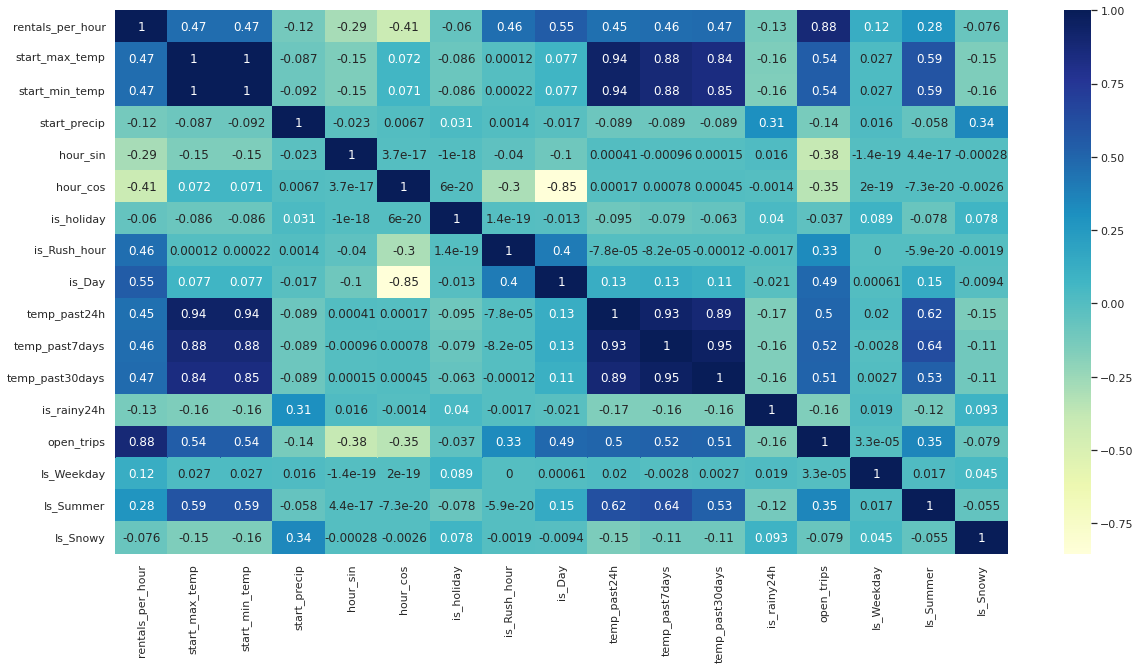

In [ ]:
sb.set(rc = {'figure.figsize':(20,10)})
dp = sb.heatmap(df_h.corr(), cmap='YlGnBu', annot=True)

## Export of the new DataFrame for further tasks

In [ ]:
df_h.to_pickle('Df_Prediction.pk')

#References

[1] D. Kaleko, "Feature Engineering - Handling Cyclical Features SOHCAHTOA amirite?", October 30, 2017. [Online]. Available: From Neutrinos to Data Science, https://blog.davidkaleko.com/feature-engineering-cyclical-features.html. [Accessed January 31, 2022].